In [1]:
import sys
sys.path.append("gpib_instrument_control")
import hp_3478a
import hp_8700_series_vna
import numpy as np
import time
import yig_controller_test
import matplotlib.pyplot as plt
import scipy.io as sio
import skrf.network

plt.rcParams['figure.figsize'] = [15, 10]


yigControllerPort='/dev/ttyUSB0'
vna = hp_8700_series_vna.Hp8753A()
curMeter = hp_3478a.Hp3478A()
yc = yig_controller_test.YigController(yigControllerPort)

Waiting for init... Done


In [3]:
wr = np.linspace(-32768, 32767, 128, dtype=np.int16)
yigChs = range(6)

zeros = []
channels=[]
for c in yigChs:
    yc.yigA.set(c, wr[0])
    time.sleep(5);
    current=[]
    for w in wr:
        yc.yigA.set(c, w);
        #time.sleep(0.5)
        current.append(curMeter.readValue())
    channels.append(current)
    yc.yigA.set(6, 0)
    time.sleep(3)
    zeros.append(curMeter.readValue())
        


In [4]:
import scipy.io as sio
sio.savemat('yig_filter_driver_current_data.mat', {'zeros':zeros, 'channels':channels, 'wr':wr})

In [5]:
d=sio.loadmat('yig_filter_driver_current_data.mat')
zeros=d['zeros'][0]
channels=d['channels']
wr=d['wr'][0]

In [6]:
print(zeros)

[0.28285 0.28304 0.283   0.2831  0.28308 0.2831 ]


Filter 0 has current from 0.011250 to 0.082660 [A] in control word range -25028 - 27606 [LSB]
Filter 1 has current from 0.025850 to 0.227370 [A] in control word range -26060 - 27606 [LSB]
Filter 2 has current from 0.029780 to 0.265550 [A] in control word range -26060 - 27606 [LSB]
Filter 3 has current from 0.054290 to 0.495160 [A] in control word range -26060 - 25026 [LSB]
Filter 4 has current from 0.100720 to 1.024580 [A] in control word range -26060 - 27606 [LSB]
Filter 5 has current from 0.101480 to 0.851460 [A] in control word range -26060 - 18318 [LSB]


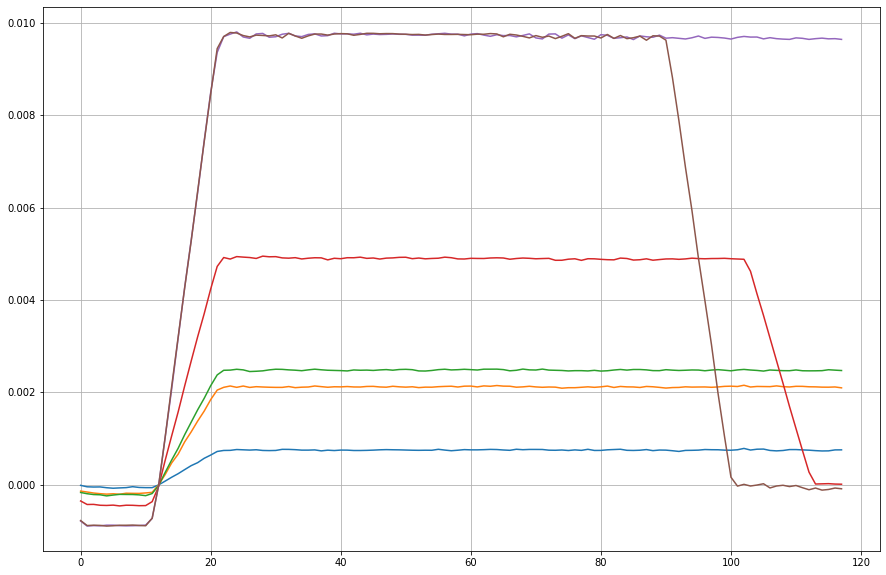

In [7]:
charr = np.array(channels)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

class FilterParameters:
    def __init__(self, lc, hc, lw, hw):
        self.lc=lc
        self.hc=hc
        self.lw=lw
        self.hw=hw

        
fParams=[]
for i in range(len(zeros)):
    avgd = moving_average(np.diff(charr[i,:]), 10)
    plt.plot(avgd)
    plt.grid(True)
    idxs = np.where(avgd>0.0002);
    mii=idxs[0][0]
    mai=idxs[0][-1]
    zc = zeros[i]
    mic=charr[i,mii]-zc
    mac=charr[i,mai]-zc
    #print(idxs[0])
    print("Filter %i has current from %f to %f [A] in control word range %d - %d [LSB]"%(i, mic, mac, wr[mii], wr[mai]))
    fParams.append(FilterParameters(mic, mac, wr[mii], wr[mai]))
    

Filter 0
[0.00000e+00 0.00000e+00 1.98700e+08 1.98700e+08 1.49025e+08 1.98700e+08
 1.98700e+08]
Filter 1
[0.00000e+00 5.46425e+08 5.46425e+08 5.46425e+08 5.96100e+08 5.46425e+08
 5.46425e+08]
Filter 2
[0.00000e+00 4.96750e+08 6.45775e+08 6.45775e+08 6.45775e+08 6.45775e+08
 6.45775e+08]
Filter 3
[5.464250e+08 1.192200e+09 1.241875e+09 1.192200e+09 1.241875e+09
 1.192200e+09 1.142525e+09]
Filter 4
[1.043175e+09 2.583100e+09 2.533425e+09 2.533425e+09 2.533425e+09
 2.483750e+09 2.583100e+09]
Filter 5
[8.44475e+08 2.48375e+09 2.48375e+09 2.48375e+09 2.48375e+09 2.48375e+09
 2.38440e+09]
0.428050 to 1.371875 [GHz]
0.676425 to 4.004650 [GHz]
0.875125 to 4.600750 [GHz]
0.875125 to 8.624425 [GHz]
1.818950 to 18.112350 [GHz]
2.067325 to 17.714950 [GHz]


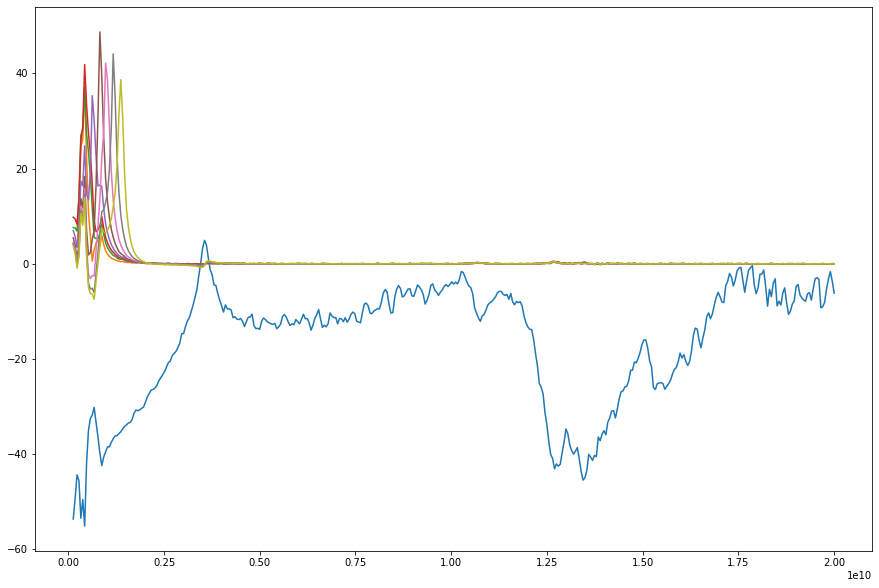

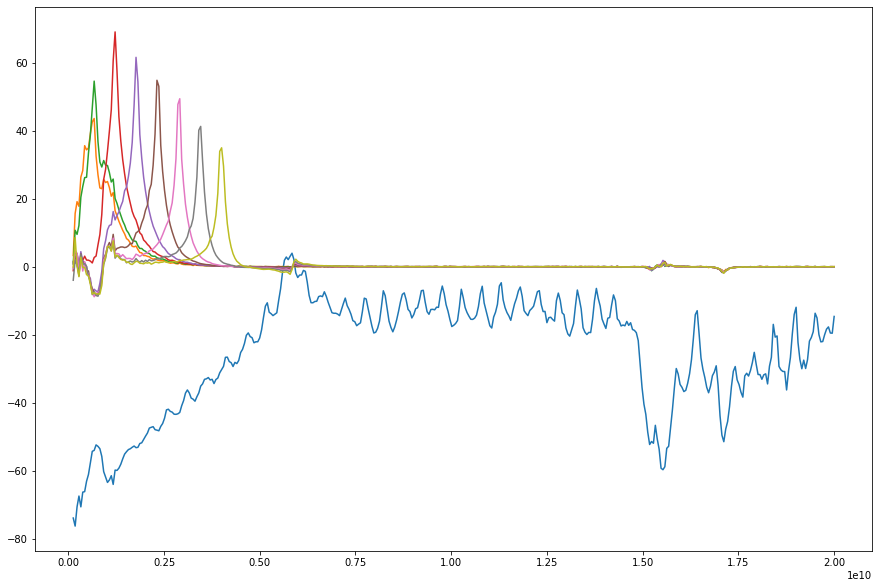

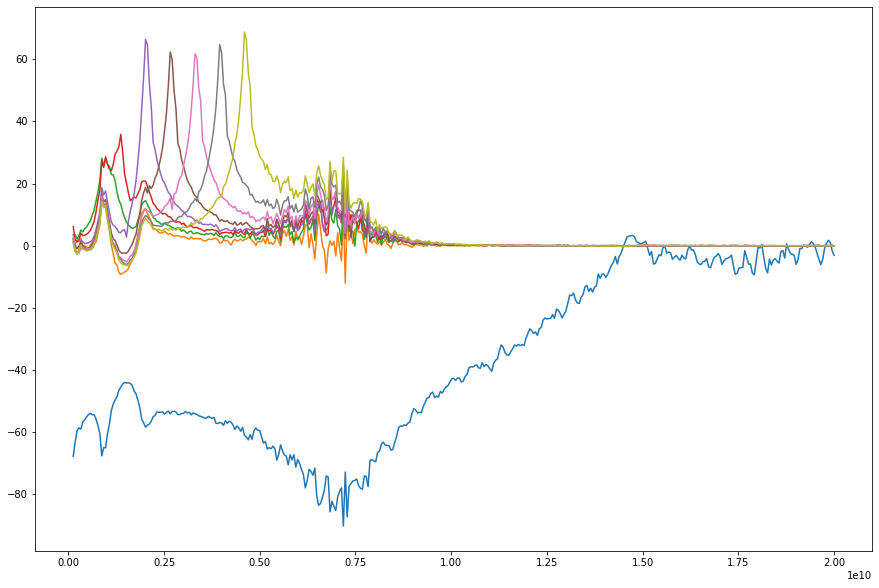

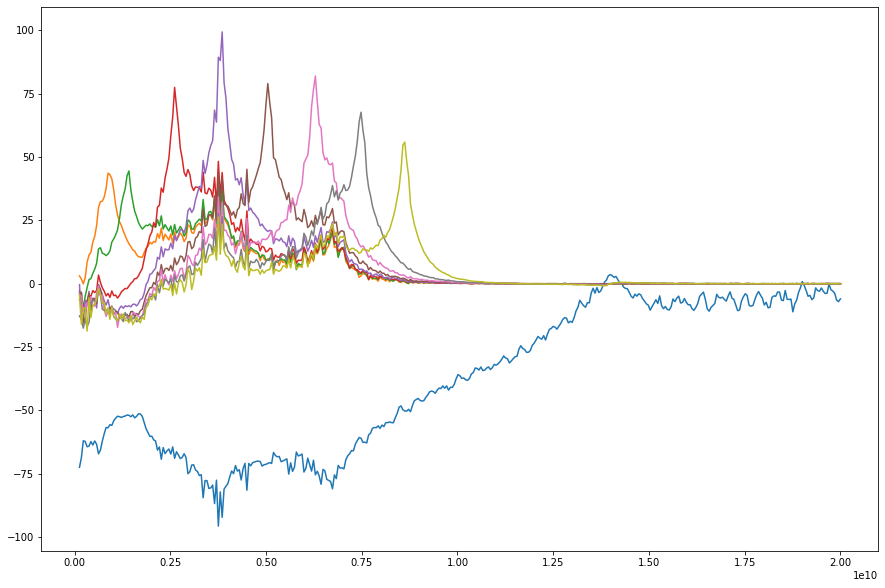

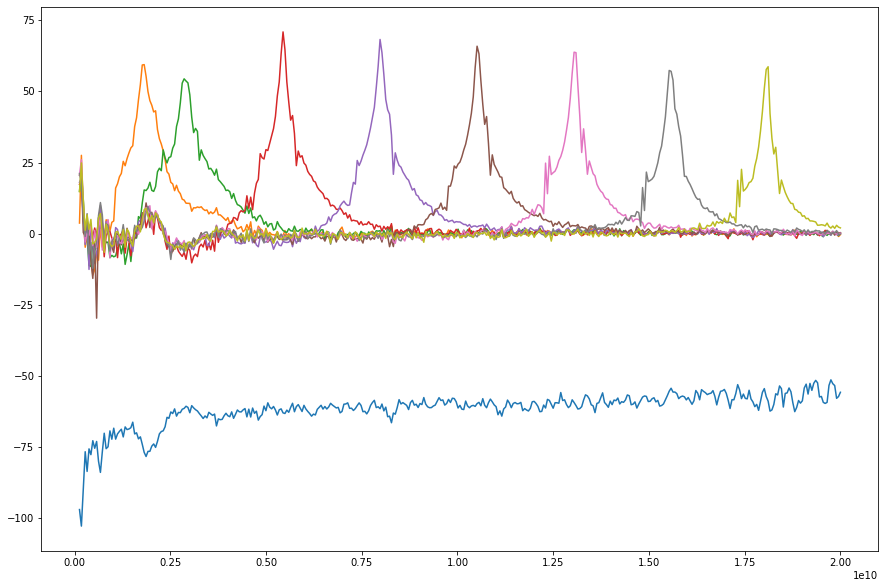

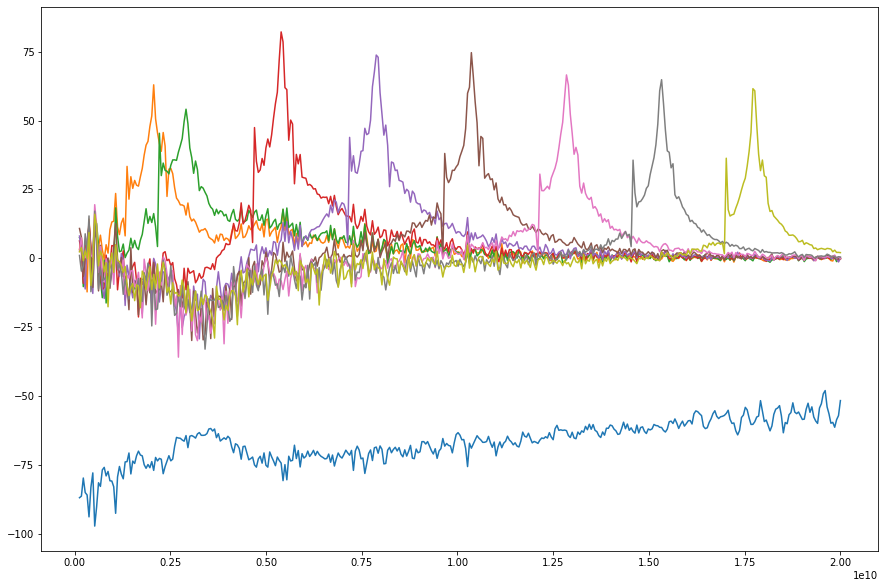

<Figure size 1080x720 with 0 Axes>

In [8]:
vna.setStartFrequency(130e6)
vna.setStopFrequency(20e9)
vna.setPoints(401)

fRanges=[]
for i in range(len(zeros)):
    print("Filter", i )
    fp = fParams[i]
    yc.switchA.set(i+1)
    yc.yigA.set(6, 0)
    fax = vna.frequencies()
    base = vna.readSParameter('S21')
    plt.plot(fax, 20*np.log10(np.abs(base)))
    sr = np.linspace(fp.lw, fp.hw, 8)
    freqs=[]
    
    for w in sr:
        yc.yigA.set(i, int(w))
        time.sleep(1)
        t = vna.readSParameter('S21')
        #traces.append(t)
        delt = np.abs(t)/np.abs(base)
        freqs.append(fax[np.argmax(delt)])
        plt.plot(fax, 20*np.log10(delt))
    mif=np.min(freqs)
    maf=np.max(freqs)
    #print(freqs)
    print(np.diff(freqs))
    fRanges.append((mif, maf))
    
    plt.figure()

for fmi, fma in fRanges:
    print("%f to %f [GHz]"%(fmi/1e9, fma/1e9))

import scipy.io as sio
sio.savemat('yig_filter_driver_coarse_frequency.mat', {'fRanges':fRanges})

In [ ]:
#Get calibration data
calPar=vna.getHighResolutionNetwork(130e6, 20e9, 1e6)
calPar.plot_s_db()
calPar.write_touchstone('cal_through.s2p')

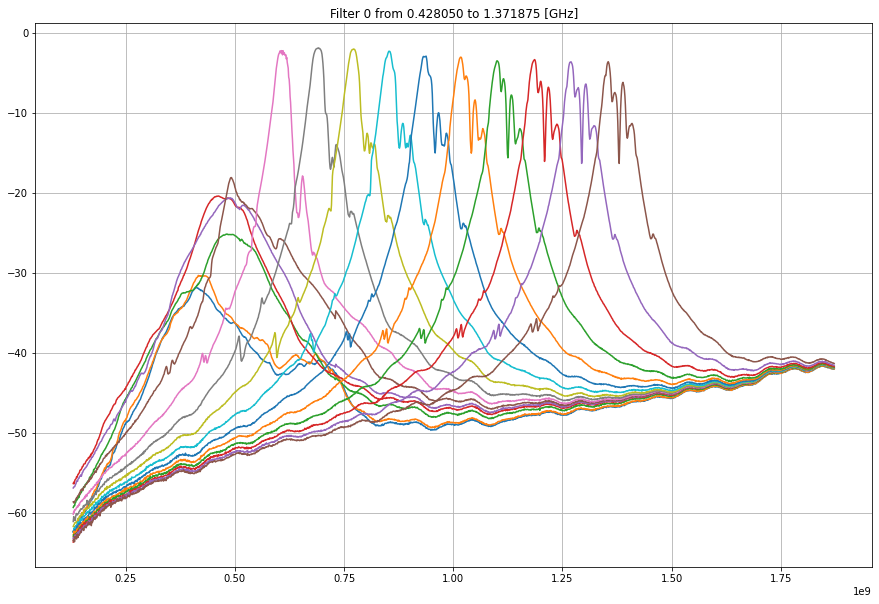

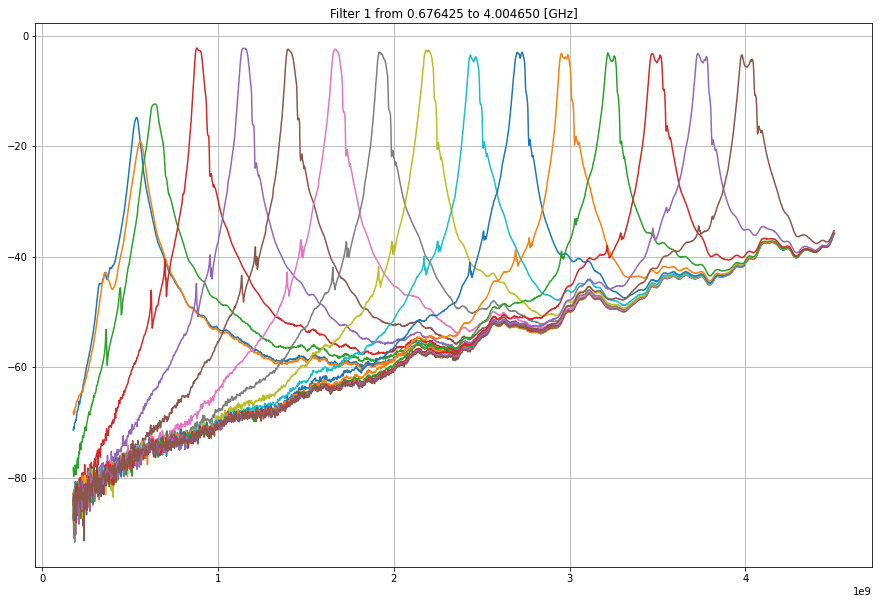

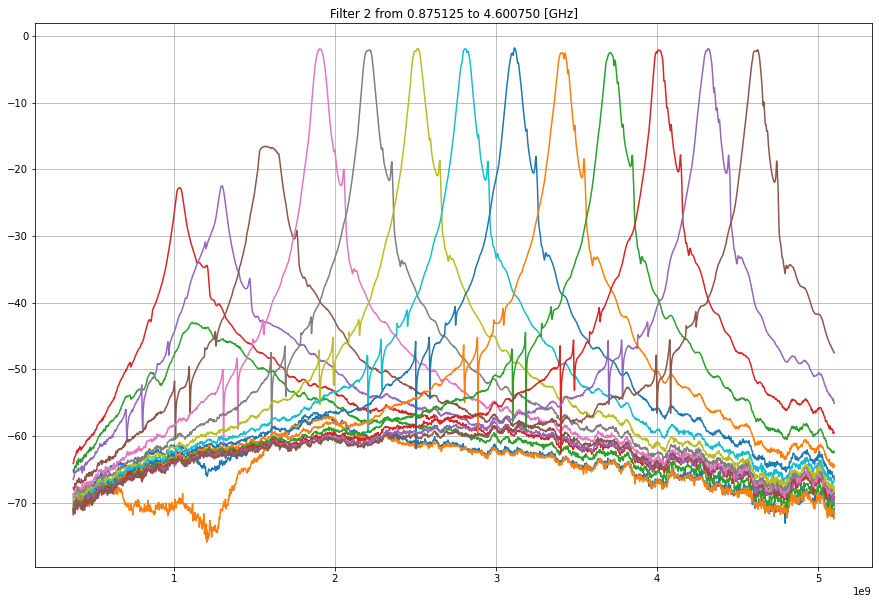

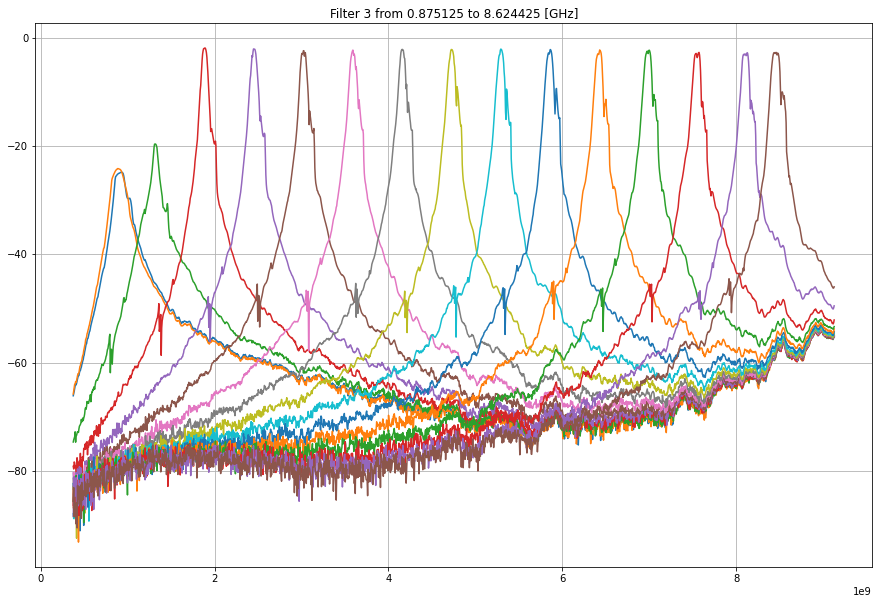

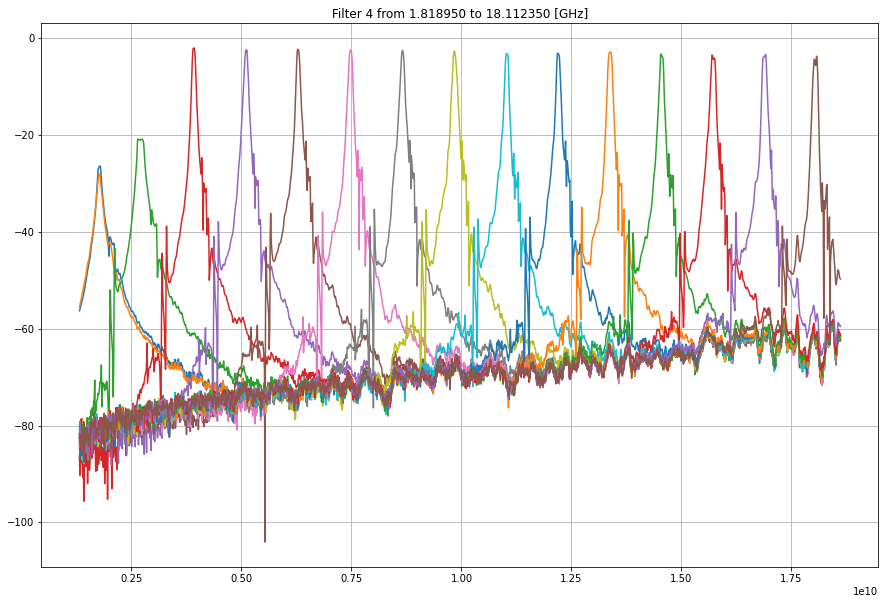

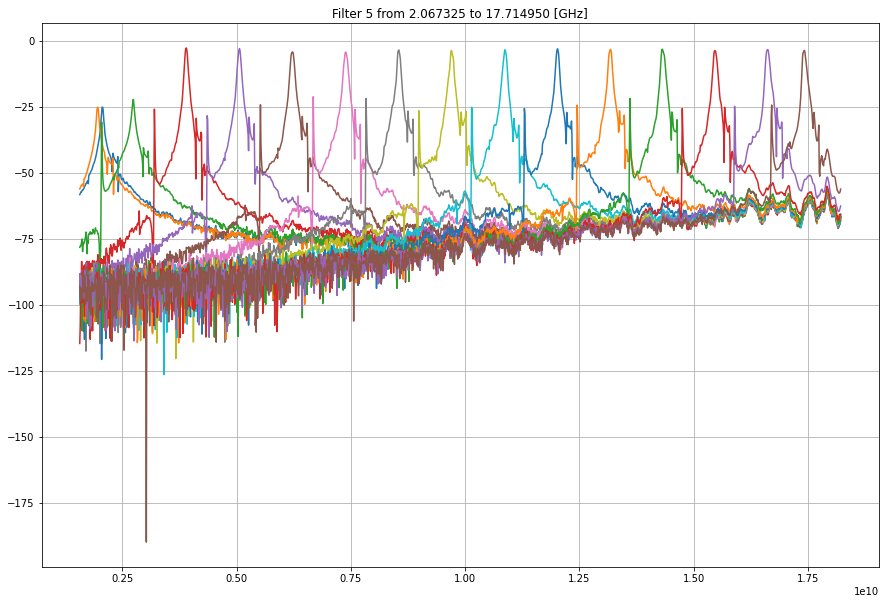

In [37]:
import skrf.network

calPar=skrf.network.Network('cal_through.s2p')
d=sio.loadmat('yig_filter_driver_current_data.mat')
zeros=d['zeros'][0]
channels=d['channels']
wr=d['wr'][0]

d2=sio.loadmat('yig_filter_driver_coarse_frequency.mat')
fRanges=d2['fRanges']
#print(fRanges)
#print(channels)
#print(wr)

def inter(fd, fa, a):
    afd=np.interp(fd, fa, a)
    return afd
    

for i in range(len(zeros)):
    yc.switchA.set(i+1)
    fsta=fRanges[i,0]-500e6
    fsta=np.max((fsta, 130e6))
    fsto=fRanges[i,1]+500e6
    fsto=np.min((fsto, 20e9))
    vna.setStartFrequency(fsta)
    vna.setStopFrequency(fsto)
    vna.setPoints(1601)
    vwr = np.linspace(fParams[i].lw, fParams[i].hw, 16)
    plt.figure()
    plt.title("Filter %d from %f to %f [GHz]"%(i, fRanges[i,0]/1e9, fRanges[i,1]/1e9))
    for w in vwr:
        yc.yigA.set(i, int(w))
        time.sleep(0.5)
        tr = vna.readSParameter('S21')
        fr = vna.frequencies()
        cai=inter(fr, calPar.f, np.abs(calPar.s[:,1,0]))
        #nf, npar = norm(calPar.f, np.abs(calPar.s[:,0,1]), fr, np.abs(tr))
        #plt.plot(nf, npar)
        plt.plot(fr, 20*np.log10(np.abs(tr)/cai))
        #plt.plot(fr, cai)
    plt.grid(True)
    plt.show()
        
    